In [ ]:
# Ejecutar si es Colab
!pip install flashtorch

In [3]:
import sys
import os

import cv2
import torch
import numpy as np
import seaborn as sn

from PIL import Image
from torch import nn

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, classification_report

from scipy.stats import entropy

from flashtorch.saliency import Backprop
from flashtorch.activmax import GradientAscent
from flashtorch.utils import *

import warnings
warnings.filterwarnings('ignore')

### Indice
1. Obtención del dataset
2. Analisis del dataset
3. Preprocesamiento del dataset
4. Entrenamiento del modelo
5. Evaluacion del modelo
6. Probando otro modelo
7. Probando un modelo pre-entrenado
8. Analisis de los modelos
9. Extra
10. Conclusiones
11. Referencias

#### 1. Obtención del dataset

Para la realizacion del Caso Kaggle, he decidido buscar un dataset similar al del https://www.kaggle.com/kvpratama/pokemon-images-dataset, ya que para lo que tenia en mente necesitaba la variante shiny de cada pokemon.
Para ello he utilizado la siguiente pagina https://pokemondb.net/pokedex/shiny y he extraido las imagenes de todos los pokemons.  
Para ello he preparado un script en javascript que busca las imagenes de todos los pokemons y coge la url de la imagen de shiny y el normal:

    function getUrls(class_name) {
        imgs_normal = document.getElementsByClassName(class_name);
        str = "";
        for (let i = 0; i < imgs_normal.length; i++) {
            if (imgs_normal[i].src != undefined) {
                str += imgs_normal[i].src + '\n';
            }
        }
        return str;
    }

    normal = getUrls('shinydex-sprite-normal');
    shini = getUrls('shinydex-sprite-shiny');

Con este obtenemos lo siguiente:    

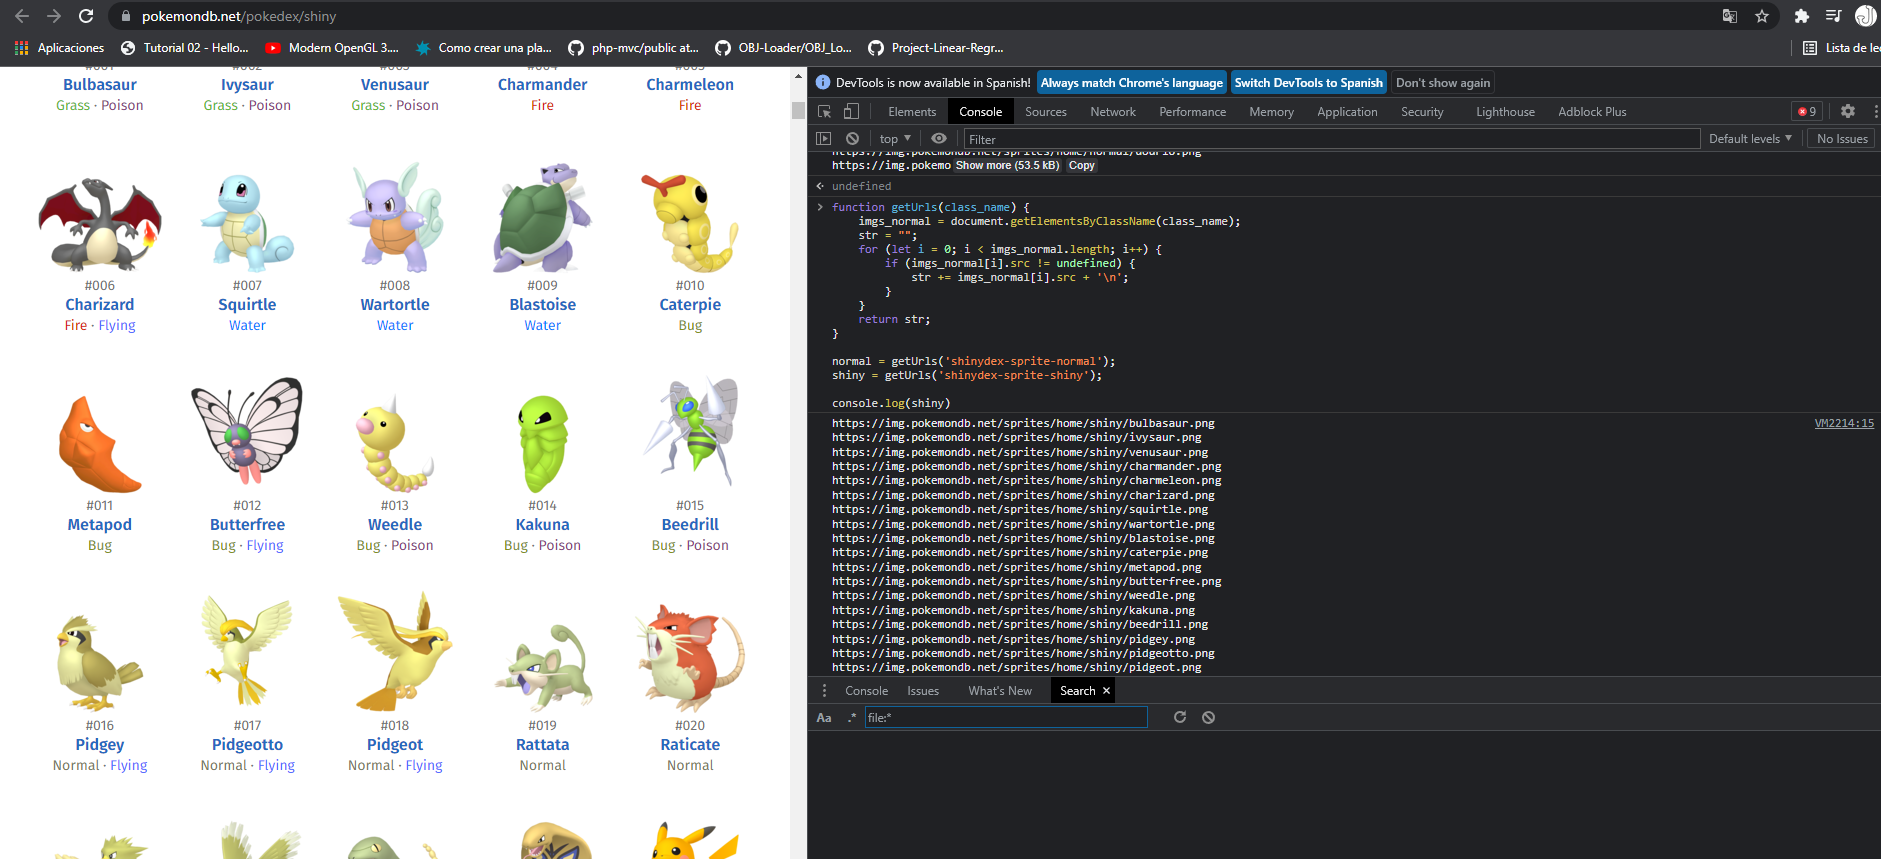

Como se puede apreciar en la imagen podemos ver todas las url de las imagenes de los pokemons.  
A continuacion utilizando la libreria `requests` de python he descargado las imagenes de los pokemons en formato png, el codigo es el siguiente:

    import requests

    FILE_NORMAL = 'links_normal.txt'
    FILE_SHINY = 'links_shiny.txt'

    DOWNLOADED_FOLDER = '../dataset/'

    def downloader(file_name):
        lines = open(file_name, 'r').read().split('\n')
        for line in lines:
            if line == '': continue
            url = line.split('/')
            name_img = DOWNLOADED_FOLDER + url[-2] + "/" + url[-1]
            print(f'Downloading {name_img}...')
            r = requests.get(line)
            open(f'{name_img}', 'wb').write(r.content)
            
    if __name__ == '__main__':
        downloader(FILE_NORMAL)
        downloader(FILE_SHINY)

De esta manera conseguimos descargar las imagenes de los pokemons y separarlas en dos carpetas, una para las imagenes normales y otra para las imagenes shiny.

**Antes de seguir con el caso Kaggle**, tuve problemas con el modelo que escogi (Pix2Pix, que es una GAN), el proposito era poder pasar de un Pokemon normal a un Pokemon shiny, el principal problema que he tenido ha sido el alto coste de entrenamiento de este modelo para el problema que queria afrontar. Por ese motivo He cambiado el proposito del Kaggle, el objetivo es ver si un modelo de red neuronal, mas sencillo que el anterior mencionado es capaz de distingir entre Pokemons y Digimons. El dataset de Digimon lo he consegido del siguiente repositorio git: https://github.com/DeathReaper0965/Digimon-Generator-GAN/blob/master/Digimon.zip 

#### 2. Analisis del dataset

En este apartado voy a analizar el dataset y ver las imagenes descargadas, su resolucion y informacion adicionar, como la complejidad de los trazos del dibujo y la escala de colores de cada imagen. Empizo creando funciones para la lectura de la imagenes y visualizacion de diferentes maneras.

In [4]:
def read_dataset_images(path, resize_size=(256, 256), add_white_bg=True):
    """
    Reads images from a directory and returns a list of images.
    """
    images = []
    for filename in os.listdir(path):
        png = Image.open(path + filename)
        png.load()
        # Cambiamos el formato de la imagen a RGB con el fondo a blanco
        if add_white_bg:
            background = Image.new("RGB", png.size, (255, 255, 255))
            background.paste(png, mask=png.split()[3])
            png = background
        # Redimensionamos la imagen
        png = png.resize(resize_size, Image.ANTIALIAS)
        images.append(np.array(png))
    return images

Y cuatro funciones para mostrar imagenes:
- show_images: muestra un conjunto de imagenes en una cuadricula
- show_eval: misma funcionalidad que la funcion show_images, pero muestra la confidencia de cada clase
- load_img: carga una imagen y la pasa a numpy array
- test_one: realiza la inferencia de una sola imagen y la muestra.

In [5]:
def show_images(images, n_rows_cols, labels):
    fig = plt.figure(figsize=(6, 6))
    grid = ImageGrid(   fig, 111,
                        nrows_ncols=(n_rows_cols, n_rows_cols),
                        axes_pad=0.4,
                    )
    for ax, im, lb in zip(grid, images, labels):
        ax.imshow(im)
        ax.title.set_text(f'Class {lb}')
    plt.show()

def show_eval(images, n_rows_cols, labels):
    fig = plt.figure(figsize=(6, 6))
    grid = ImageGrid(   fig, 111,
                        nrows_ncols=(n_rows_cols, n_rows_cols),
                        axes_pad=0.4,
                    )
    for ax, im, lb in zip(grid, images, labels):
        ax.imshow(im)
        ax.title.set_text('P = %.2f D = %.2f'% (lb[0], lb[1]))
    plt.show()

def load_img(path):
  png = Image.open(path)
  png = png.resize((128, 128), Image.ANTIALIAS)
  return np.array(png)

def test_one(img, model):
  test = load_img(img)
  a = prepara_test_img(test)
  result = model(a)
  result = torch.sigmoid(result).cpu().detach().numpy()[0]
  plt.title(result)
  plt.imshow(test)

Esta funcion se encarga de descomprimir el dataset, para que en caso de trabajar en un entorno remoto poder subir el dataset. (Como Colab)

In [ ]:
# Codigo para Colab
!unzip dataset.zip

Ahora procedo a cargar el dataset de Digimon y Pokemon. Nada mas leerlos, los pasamos a numpy y aplicamos un fondo de color blanco a aquellos que sean PNG (en mi claso el dataset de Pokemon es el que tiene el fondo transparente), con el ultimo parametro indicamos esto.

In [8]:
DATASET_URL_DIGIMON = 'dataset/Digimon/'
DATASET_URL_POKEMON = 'dataset/Pokemon/normal/'

pokemon = read_dataset_images(DATASET_URL_POKEMON, (128, 128), True)
digimon = read_dataset_images(DATASET_URL_DIGIMON, (128, 128), False)

Una vez cargados los dataset en la memoria, lo visualizamos.

Pokemon


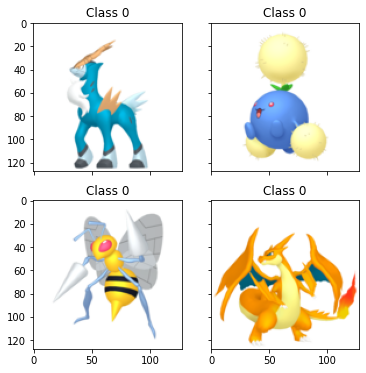

Digimon


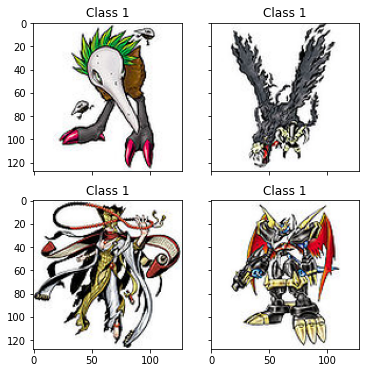

Dimension de la imagen (Pokemon):  (128, 128, 3)
Numero de imagenes (Pokemon):  895
Dimension de la imagen (Digimon):  (128, 128, 3)
Numero de imagenes (Digimon):  895


In [ ]:
print('Pokemon')
show_images(pokemon, 2, [0] * 4)
print('Digimon')
show_images(digimon, 2, [1] * 4)

print('Dimension de la imagen (Pokemon): ', pokemon[0].shape)
print('Numero de imagenes (Pokemon): ', len(pokemon))

print('Dimension de la imagen (Digimon): ', digimon[0].shape)
print('Numero de imagenes (Digimon): ', len(digimon))

Podemos observar que el dataset tiene la cantidad de 895 * 2 imagenes. Cada imagen tiene un tamaño de 128x128x3. En la parte superior de las imagenes tenemos los pokemons normales y en la parte inferior de las imagenes tenemos los digimons.

Ahora calcularemos la complejidad de los dibujos de manera mecanica sin la utilizacion de modelos de deep-learning. Para ellos aplicaremos el calculo de la entropia de Shannon. Antes de calcular la entropia aplicaremos el algorimo de Canny filter para encontrar los bordes de la imagen y asi no dar prioridad a los dibujos mas gandes.

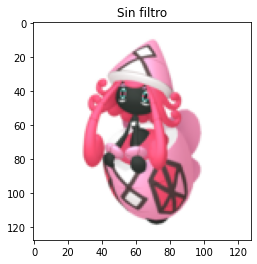

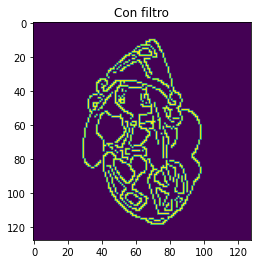

In [ ]:
plt.title('Sin filtro')
plt.imshow(pokemon[50])
plt.show()
plt.title('Con filtro')
plt.imshow(cv2.Canny(pokemon[50], 100,200))
plt.show()

El resultado de aplicar el filtro es el que se puede observar en la imagen de arriba de esta manera podemos extraer los bordes de la imagen.

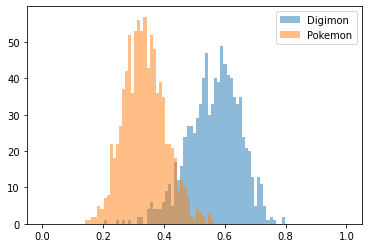

In [ ]:
def calculate_entropy(img):
  marg = np.histogramdd(np.ravel(img), bins = 256)[0]/img.size
  marg = list(filter(lambda p: p > 0, np.ravel(marg)))
  return -np.sum(np.multiply(marg, np.log2(marg)))

pokemon_en = []
digimon_en = []

for pokemon_img, digimon_img in zip(pokemon, digimon):
  pokemon_en.append(calculate_entropy(cv2.Canny(pokemon_img, 100,200)))
  digimon_en.append(calculate_entropy(cv2.Canny(digimon_img, 100,200)))

bins = np.linspace(0, 1, 100)
plt.hist(digimon_en, bins, alpha=0.5, label='Digimon')
plt.hist(pokemon_en, bins, alpha=0.5, label='Pokemon')
plt.legend(loc='upper right')
plt.show()

En las graficas se observa que de media, los dibujos de Digimon son mas complejos que los de Pokemon, es decir tiene mas trazos. Para ver si de verdad es asi, visualizo los Pokemons mas "complejos" y los mas "simples" y los Digimon mas "complejos" y los mas "simples".

Digimons de dibujo simples:


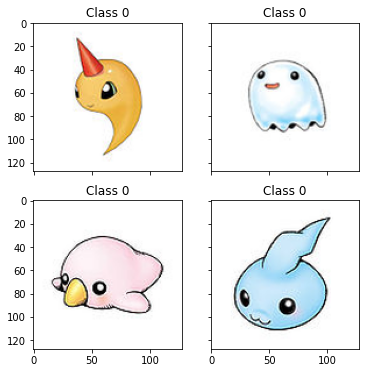

Pokemons de dibujo simples:


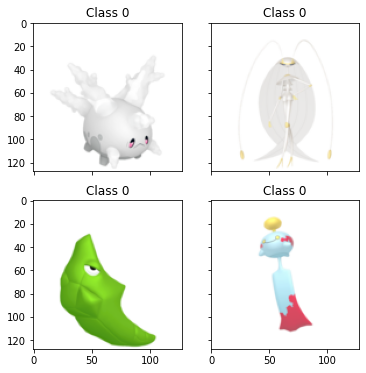

Pokemons de dibujo complejos


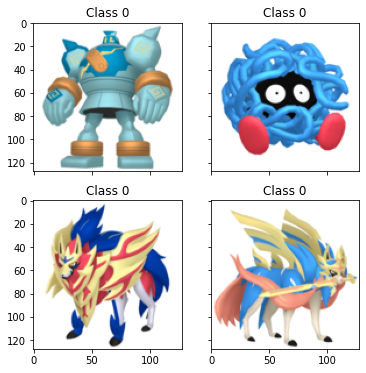

Digimons de dibujo complejo


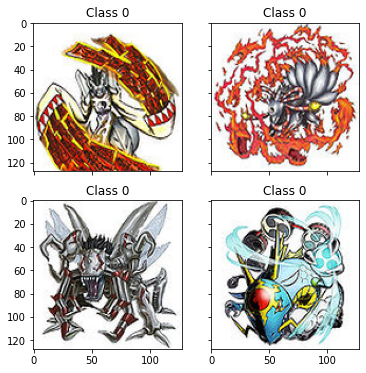

In [ ]:
pokemons_img, _ = list(zip(*sorted(list(zip(pokemon, pokemon_en)), key = lambda x: x[1])))
digimons_img, _ = list(zip(*sorted(list(zip(digimon, digimon_en)), key = lambda x: x[1])))

pokemons_img = list(pokemons_img)
digimons_img = list(digimons_img)

print('Digimons de dibujo simples:')
show_images(digimons_img, 2, [0] * 4)
print('Pokemons de dibujo simples:')
show_images(pokemons_img, 2, [0] * 4)
pokemons_img.reverse()
print('Pokemons de dibujo complejos')
show_images(pokemons_img, 2, [0] * 4)
digimons_img.reverse()
print('Digimons de dibujo complejo')
show_images(digimons_img, 2, [0] * 4)

Podemos ver que si se cumple el histograma, los Digimons mas "complejos" son bastante mas "complejos" que los Pokemon.

#### 3. Preprocesamiento del dataset

En esta apartado vamos realizar un preprocesamiento de las imagenes, como el dataset solo cuenta con 1790 imagenes y vamos a querer crear datos de train, validation y test, realizaremos un aumento de los datos y normalizacion. A continuacion vemos unas funciones para realizar este tratamiento:

In [6]:
def normalization(img):
  newX = []
  for i in img:
    newX.append(i/255)
  newX = np.stack(newX)
  newX = torch.Tensor(newX)
  return newX

def flip_image_vertical(inimg):
    '''
        Flipamos la imagen
    '''
    inimg = np.flip(inimg, 1)
    return inimg

def flip_image_horizontal(inimg):
    '''
        Flipamos la imagen
    '''
    inimg = np.flip(inimg, 0)
    return inimg

def to_tensor(X):
    new = []
    trans = transforms.ToTensor()
    for x in X: new.append(trans(x))
    return torch.Tensor(new)

def change_axis(X):
    new_X = []
    for x in X:
        new_X.append(np.transpose(x, (2, 0, 1)))
    return new_X

def data_augmentation(X, y):
    new_X = []
    new_y = []
    for i in range(len(X)-2):
        x_t = flip_image_vertical(X[i])
        new_X.append(x_t)
        new_y.append(y[i])

        x_t = flip_image_horizontal(X[i+1])
        new_X.append(x_t)
        new_y.append(y[i+1])

        x_t = flip_image_vertical(X[i+2])
        x_t = flip_image_horizontal(x_t)
        new_y.append(y[i+2])
        new_X.append(x_t)

    return new_X, new_y


Una vez que tenemos las funciones definidas vamos a aplicarlas sobre nuestro dataset, pero antes vamos a separa en datos de entremiento y test, ya que las imgenes de test no quiero que sean tratadas. De las 1790 imagenes el 70% seran para entrenamiento y validacion y el 30% de test.

In [9]:
# Agrupamos en el mismo datset las imagenes de pokemon y digimon
TRAIN_SIZE = 0.70

# Agrepamos en la misma lista las imagenes
X = pokemon + digimon

# Creamos las etiquetas
y = [0] * len(pokemon) + [1] * len(digimon)

# Agremaos las imagenes y las etiquetas
dataset = list(zip(X, y))

# Mezclamos
np.random.seed(42)
np.random.shuffle(dataset)

# Separamos el dataset en X e y (y Train y Test)
X_train, y_train = zip(*dataset[:int(TRAIN_SIZE * len(dataset))])
X_test, y_test = zip(*dataset[int(TRAIN_SIZE * len(dataset)):])

In [ ]:
print('Imagenes train/validacion:', len(X_train))
print('Imagenes test:', len(X_test))

Imagenes train/validacion: 1253
Imagenes test: 537


Podemos ver que nos acaba quedando 1253 imagenes de train y 537 de test. Ahora pasaremos a aplicar la normalizacion y el data-aumentation a los datos de test.

In [ ]:
# Aumentamos los datos con las siguiente tranformaciones:
# Volteado vertical
# Volteado horizontal
# Los dos
X_train, y_train = data_augmentation(X_train, y_train)

# Cambiamos el axis de cada imagen, pasamos de 128, 128, 3 --> 3, 128, 128
X_train = change_axis(X_train)

# Lo pasamos a numpy array
X_train = np.stack(X_train)

# Lo pasamos a un tensor de pytorch
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).type(torch.LongTensor) # Long porque es categorico

X_train = normalization(X_train)

# Ahora lo pasamos a la clase Dataset propia de Pytorch
train_dataset = TensorDataset(X_train, y_train)
train_set_size = int(len(train_dataset) * 0.85)
valid_set_size = len(train_dataset) - train_set_size
train_set, valid_set = torch.utils.data.random_split(train_dataset, [train_set_size, valid_set_size])

# Creamos los DataLoader con un batch_size de 16 para que el entreno sea mas rapido.
train_set = DataLoader(train_set, batch_size=16, shuffle=True)
valid_set = DataLoader(valid_set, batch_size=16, shuffle=True)

A continuacion podemos ver como ha funcionado el data-aumentation. Ya que la imagen se encuntra volteda. Tambine esta aplicada la normalizacion.

tensor([0.6667, 0.3098, 0.4000])


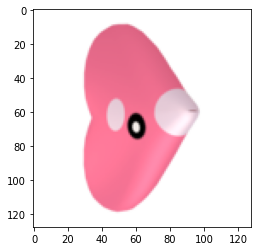

In [ ]:
plt.imshow(X_train[5].permute(1, 2, 0).float())
print(X_train[5].permute(1, 2, 0)[65][65])

Finalmente nos queda las siguientes cantidades despues de aplicar data-aumentation:

In [ ]:
print('Datos de entreamiento:', len(train_set)*train_set.batch_size)
print('Datos de validacion:', len(valid_set)*valid_set.batch_size)
print('Datos de test:', len(X_test))

Datos de entreamiento: 3200
Datos de validacion: 576
Datos de test: 537


#### 4. Entrenamiento del modelo

Ahora pasaremos a probar diferentes modelos a ver cual es el que mejor se ajusta a nuestro problema. Emepzaremos con el mas sencillo de los que se encuentra en los predefinidos por pytorch (son modelos populares, que dieron buenos resultados en diferentes competiciones), el primer modelo a probar sera Alexnet. El optimizador que he escogido ha sido Adam con un learning-rate del 0.000001 (que despues de unas pocas pruebas he visto que hace converger bien el modelo en 30 epocas).

En caso de tener el modelo entrenado no es necesario volver a entrenarlo, para ello lo cargamos de la carpeta models:

In [ ]:
def alexnet():
    # Cargamos el modelo
    model = models.alexnet()
    # Modificamos la capa de salida para que solamente tenga 2 neuronas
    model.classifier[6] = nn.Linear(4096, 2)
    model.eval()
    # Mostramos el modelo
    print(model)
    return model

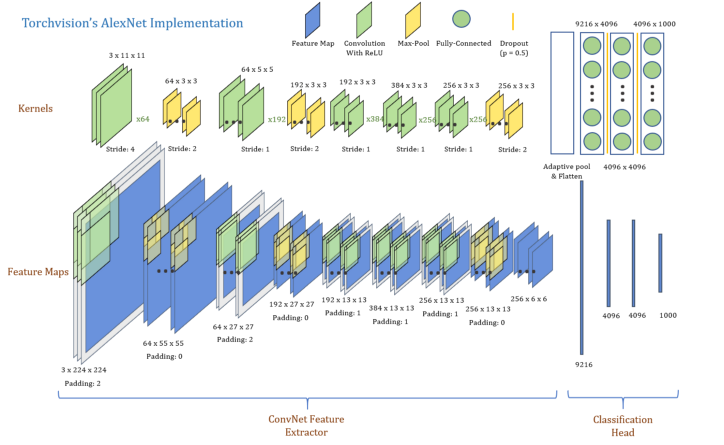

En la imagen podemos observar la arquitectura escogida, cabe mencionar, que tanto el input como el output no corresponde a la imagen, ya que el intput sera de 128x128px (esto el propio pytorch se encarga de cambiarlo) y el output lo cambiamos a mano con la siguiente `linea model.classifier[6] = nn.Linear(4096, 2)` asi consegimos tener dos salidas que despues podemos aplicar un argmax si queremos el valor final de la prediccion o una funcion sigmoid para tener el % clase que es como veremos mas adelante.

En caso de no querer entrenar el modelo, podemos cargarlo de la siguiente manera, este entrenamiento se ha realizado en la nube con las graficas de Google Colab.

In [ ]:
checkpoint = torch.load('drive/MyDrive/models/alexnet.pt')
model = alexnet()
model.cuda()
model.load_state_dict(checkpoint['model_state_dict'])
train_loss = checkpoint['train_loss']
validation_acc = checkpoint['validation_acc']

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

En caso de querer entrenar el modelo podemos utilizar la siguientes 3 celdas:

In [ ]:
train_on_gpu = torch.cuda.is_available()

model = alexnet()
# Creamos el optimizador y el criterio de error
optimizer = optim.Adam(model.parameters(), lr=0.000001)
criterion = nn.CrossEntropyLoss()

if train_on_gpu: model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Vemos que la capa de salida ahora tiene 2 features `(6): Linear(in_features=4096, out_features=2, bias=True)`

Crearemos funciones para entrenar y validar nuestro modelos, asi podemos ir viendo como se entrenando nuestro modelo.

In [ ]:
def train(model, optimizer, criterion, train_set, info, train_loss):
      running_loss = 0.0
      for i, data in enumerate(train_set, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          output = model(inputs)
          loss = criterion(output, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % info == 1 and i != 0:
            sys.stdout.write(f'\rEpoca {epoch + 1} Batch {i + 1} Train loss { running_loss / info }')
            train_loss.append(running_loss / info)
            running_loss = 0.0

def validate(model, criterion, valid_set, validation_acc):                       
    correct = 0                                               
    total = 0                                                 
    running_loss = 0.0                                        
    model.eval()                                              
    with torch.no_grad():                                     
        for i, data in enumerate(valid_set):                     
            inputs, labels = data                             
            inputs = inputs.to(device)                        
            labels = labels.to(device)                        
                                                              
            outputs = model(inputs)                           
            loss = criterion(outputs, labels)                 
            _, predicted = torch.max(outputs.data, 1)         
            total += labels.size(0)                           
            correct += (predicted == labels).sum().item()     
            running_loss = running_loss + loss.item()         
    mean_val_accuracy = (100 * correct / total)               
    mean_val_loss = ( running_loss )        
    print('\nValidation Accuracy: %d %%' % (mean_val_accuracy)) 
    print('Validation Loss:' , mean_val_loss )     
    validation_acc.append(mean_val_accuracy)

En la funcion de entrenamiento vamos a ir guardando cada 10 iteraciones, el loss del entrenamiento y mostraremos por pantalla el avance. En cambio la validacion solamente la haremos cada epoca. El numero de epocas es de 30.

In [ ]:
validation_acc = []
train_loss = []

for epoch in range(30):  # loop over the dataset multiple times
  train(model, optimizer, criterion, train_set, 10, train_loss)
  validate(model, criterion, valid_set, validation_acc)

print('Finished Training of AlexNet')

Epoca 1 Batch 192 Train loss 0.6864754557609558
Validation Accuracy: 45 %
Validation Loss: 24.61033570766449
Epoca 2 Batch 192 Train loss 0.5206470519304276
Validation Accuracy: 87 %
Validation Loss: 17.78410366177559
Epoca 3 Batch 192 Train loss 0.20303622260689735
Validation Accuracy: 90 %
Validation Loss: 8.378795735538006
Epoca 4 Batch 192 Train loss 0.23342594504356384
Validation Accuracy: 92 %
Validation Loss: 6.827998608350754
Epoca 5 Batch 192 Train loss 0.19033642411231994
Validation Accuracy: 92 %
Validation Loss: 7.302201382815838
Epoca 6 Batch 192 Train loss 0.16615437269210814
Validation Accuracy: 93 %
Validation Loss: 5.844204254448414
Epoca 7 Batch 192 Train loss 0.14269529320299626
Validation Accuracy: 93 %
Validation Loss: 5.590006528422236
Epoca 8 Batch 192 Train loss 0.17096865996718408
Validation Accuracy: 94 %
Validation Loss: 6.258397417142987
Epoca 9 Batch 192 Train loss 0.18824777826666833
Validation Accuracy: 94 %
Validation Loss: 6.2511510625481606
Epoca 10 Ba

Una vez entrenado, para almacenar el estado de entrenaminto y los pesos del modelos, utilizamos la funcion save de pytorch. La informacion que almacenamos es la siguiente:
- epoch: numero de epocas donde nos hemos quedado entrenando el modelo
- model_state_dict: estado del modelo
- optimizer_state_dict: estado del optimizador
- loss: loss del entrenamiento
- train_loss: lista de todos los losses del entrenamiento
- validacion_loss: lista de todos los losses de validacion 

In [ ]:
torch.save({
            'epoch': 30,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss[-1],
            'train_loss': train_loss,
            'validation_acc': validation_acc
            }, 'models/alexnet.pt')

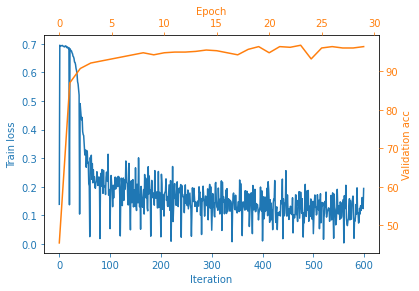

Last train loss: 0.19413039572536944 Last validation acc: 96.44760213143873


In [ ]:
def plot_train_loss_acc(train_loss, validation_acc):
  fig=plt.figure()
  ax=fig.add_subplot(111, label="train")
  ax2=fig.add_subplot(111, label="validation", frame_on=False)

  ax.plot(train_loss, color="C0")
  ax2.plot(validation_acc, color="C1")

  ax.set_xlabel('Iteration', color="C0") 
  ax.set_ylabel('Train loss', color="C0")
  ax.tick_params(axis='x', colors="C0")
  ax.tick_params(axis='y', colors="C0")
  ax2.set_xlabel('Epoch', color="C1") 
  ax2.set_ylabel('Validation acc', color="C1")
  ax2.xaxis.tick_top()
  ax2.yaxis.tick_right()
  ax2.xaxis.set_label_position('top') 
  ax2.yaxis.set_label_position('right') 
  ax2.tick_params(axis='x', colors="C1")
  ax2.tick_params(axis='y', colors="C1")

  plt.show()

plot_train_loss_acc(train_loss, validation_acc)
print('Last train loss:',train_loss[-1], 'Last validation acc:', validation_acc[-1])

Despues de las 30 epocas, vemos que el modelo ya tiene un Acc bastante estable y del 96% con los datos de validacion, por lo que el numero de epocas es el acertado. El tiempo de entrenamiento ha sido aproximadamente de 8 minutos en la grafica que proporciona Google con el entorno Colab.

#### 5. Evaluacion del modelo

Para la evaluacion del modelo he preparado una funcion eval, que pasara por el modelo todas las imagenes de test que he guardado al principio. La funcion se encarga de predecir todas las clases de las imagenes y almacenarla en una estructura dict que contiene los siguiente:

- predictions: lista de todas las predicciones y las imagenes correspondientes.
- good_predictions: lista de las predicciones buenas y sus imagenes.
- bad_predictions: lista de las predicciones malas y sus imagenes.

In [12]:
def prepara_test_img(img, cuda = False):
  X = img/255
  X = X.transpose((2, 0, 1)).astype('float32')
  if cuda:
    return torch.tensor([X], requires_grad=True).cuda()
  else:
    return torch.tensor([X], requires_grad=True)

def eval(X_test, y_test, model, cuda = False):
  bad_predictions = []
  good_predictions = []
  predictions = []
  for img, b in zip(X_test, y_test):
      a = prepara_test_img(img, cuda)
      result = model(a)
      result = torch.sigmoid(result).cpu().detach().numpy()[0]
      if result.argmax() != b:
        bad_predictions.append((img, result))
      else:
        good_predictions.append((img, result))
      predictions.append((b, result.argmax()))

  res = list(zip(*predictions))
  return {'predictions': res, 'good_predictions': good_predictions, 'bad_predictions': bad_predictions}

def show_acc(results):
  sn.heatmap(confusion_matrix(*results['predictions']), annot=True, fmt='g')
  plt.show()
  print(classification_report(*results['predictions']))

Tambien tenemos la funcion show_acc, que genera la matriz de confusion y metricas de classificacion.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """


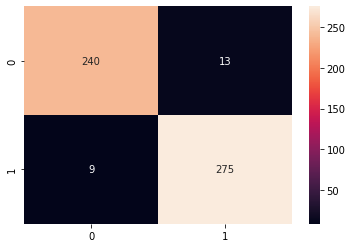

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       253
           1       0.95      0.97      0.96       284

    accuracy                           0.96       537
   macro avg       0.96      0.96      0.96       537
weighted avg       0.96      0.96      0.96       537



In [ ]:
results = eval(X_test, y_test, model, True)
show_acc(results)

Podemos ver que hemos obtenido un 0.96 de acc con los datos de test, exactamente el mismo Acc que teneniamos con los datos de validacion, esto es buena señal, ya que los datos de validacion y de test son similares. Ahora vamos a visualizar de manera grafica las imagenes erroneas con peor tasa de fallo y las imagenes correctas con mas acierto. Esto es posible realizando la operacion sigmoid con el output de las 2 neuronas. Asi podemos ver que el lo que el clasificador considera "muy" Pokemon y lo que considera "muy" Digimon.

In [ ]:
def eval_img(results):
  sorted_good_pokemon = sorted(results['good_predictions'], key= lambda x: x[1][0], reverse=True)
  sorted_good_digimon = sorted(results['good_predictions'], key= lambda x: x[1][1], reverse=True)

  sorted_bad_pokemon = sorted(results['bad_predictions'], key= lambda x: x[1][0], reverse=True)
  sorted_bad_digimon = sorted(results['bad_predictions'], key= lambda x: x[1][1], reverse=True)

  all_pred = sorted_good_pokemon + sorted_bad_pokemon
  all_pred = sorted(all_pred, key= lambda x: entropy(x[1]), reverse=True)

  demostration_img = [sorted_good_pokemon[0][0], sorted_good_digimon[0][0], sorted_bad_pokemon[0][0], sorted_bad_digimon[0][0]]
  demostration_lab = [sorted_good_pokemon[0][1], sorted_good_digimon[0][1], sorted_bad_pokemon[0][1], sorted_bad_digimon[0][1]]

  show_eval(demostration_img, 2, demostration_lab)
  show_eval([all_pred[0][0]], 1, [all_pred[0][1]])

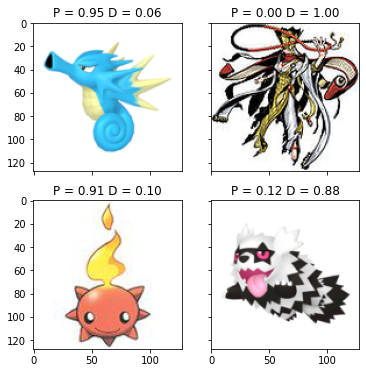

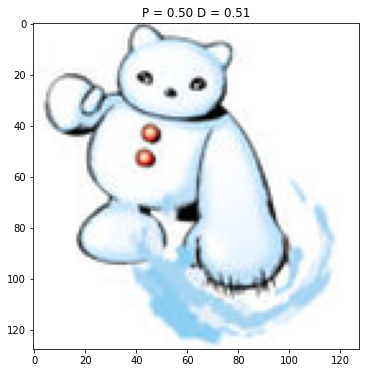

In [ ]:
eval_img(results)

En la imagen de cuadricuda de 4 imagenes, podemos ver en las dos imagenes de arriba las predicciones buenas de cada clase con mayor % en su clase, Las 2 imagenes de abajo podemos ver las imagenes con el % mas alto de la clase que no corresponde. Y por ultimo en la parte inferior vemos la imagen que mas dudas tiene el clasificador.

#### 6. Probado otro modelo
Ahora vamos a probar otro modelo mas potente, para ver como se comporta sobre el mismo dataset. El modelo escogido es vgg16. Este se compone con muchas mas capas convolucionales que Alexnex, por lo que preveo que es capaz de aprender mas patrones y texturas, esto puedo ayudar a generalizar mas el modelo.

In [10]:
def vgg():
    model = models.vgg16(init_weights=True)
    model.classifier[6]=nn.Linear(4096,2)
    print(model)
    return model

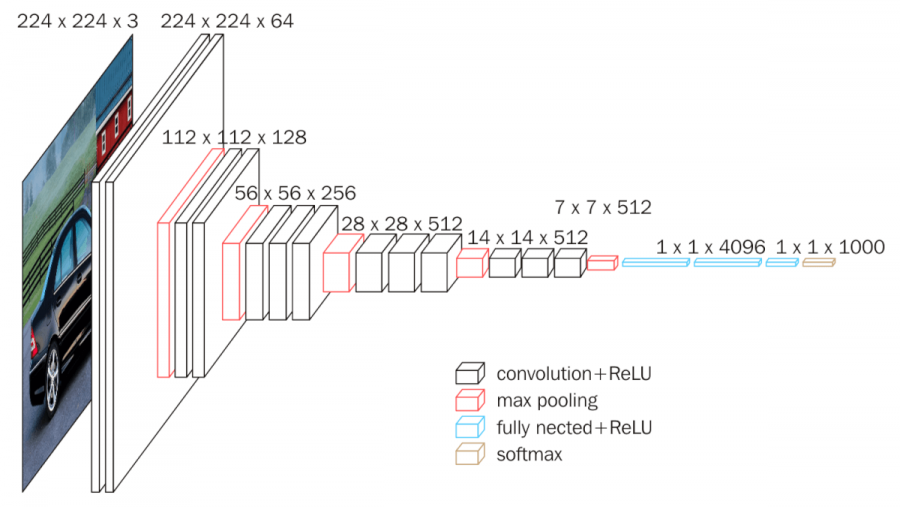

Igual que Alexnet, hemos modificado la capa de entrada y la de salida para que corresponda con el numero de clases de nuestro dataset, en nuestro caso lo hemos cambiado a 2 con la siguiente linea. `model.classifier[6]=nn.Linear(4096,2)`, ya que en el classificador la capa numero 6 es la capa de salida. Ha diferencia de Alexnet, podemos ver que contiene mas capas de convolucion. Este es el principal motivo por el que puedo aprender distintos patrones, como colores, texturas y formas.

Igual que Alexnet, tambien proporciono el modelo ya entrenado con 30 epocas. Ejecutando esta celda podemos cargarlo.

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/models/vgg.pt')
model_vgg = vgg()
model_vgg.cuda()
model_vgg.load_state_dict(checkpoint['model_state_dict'])
train_loss = checkpoint['train_loss']
validation_acc = checkpoint['validation_acc']

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

En caso de querer entrenarlo hay que ejecutar la siguiente celda.

In [ ]:
train_on_gpu = torch.cuda.is_available()
torch.cuda.empty_cache()
model_vgg = vgg()

validation_acc = []
train_loss = []

optimizer_inception = optim.Adam(model_vgg.parameters(), lr=0.000001)
criterion_inception = nn.CrossEntropyLoss()

if train_on_gpu: model_vgg.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for epoch in range(30):  # loop over the dataset multiple times
  train(model_vgg, optimizer_inception, criterion_inception, train_set, 10, train_loss)
  validate(model_vgg, criterion_inception, valid_set, validation_acc)

print('Finished Training of Inception')

Epoca 1 Batch 192 Train loss 0.6782909095287323
Validation Accuracy: 60 %
Validation Loss: 24.202041566371918
Epoca 2 Batch 192 Train loss 0.21379646509885789
Validation Accuracy: 94 %
Validation Loss: 7.544792488217354
Epoca 3 Batch 192 Train loss 0.13442380130290985
Validation Accuracy: 96 %
Validation Loss: 5.062833419069648
Epoca 4 Batch 192 Train loss 0.14674651809036732
Validation Accuracy: 97 %
Validation Loss: 3.646507401019335
Epoca 5 Batch 192 Train loss 0.11761846374720335
Validation Accuracy: 97 %
Validation Loss: 3.178565138950944
Epoca 6 Batch 192 Train loss 0.07367573631927371
Validation Accuracy: 98 %
Validation Loss: 2.7855377211235464
Epoca 7 Batch 192 Train loss 0.1128384506329894
Validation Accuracy: 97 %
Validation Loss: 2.8363937698304653
Epoca 8 Batch 192 Train loss 0.1162945058196783
Validation Accuracy: 98 %
Validation Loss: 2.350607785396278
Epoca 9 Batch 192 Train loss 0.09975606189109384
Validation Accuracy: 97 %
Validation Loss: 2.581496083177626
Epoca 10 B

Una vez entrenado el modelo almacenamos el estado actual. El tiempo de entreno ha sido de 29 minutos. Con un batch size de 16 y utlizando colab de Google.

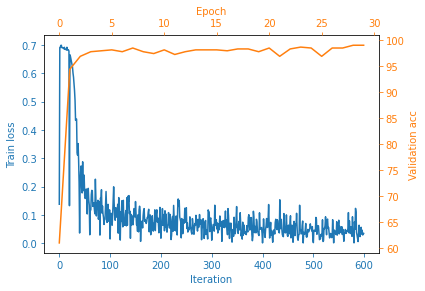

Last train loss: 0.03455079877749086 Last validation acc: 98.93428063943162


In [ ]:
plot_train_loss_acc(checkpoint['train_loss'], checkpoint['validation_acc'])
print('Last train loss:',train_loss[-1], 'Last validation acc:', validation_acc[-1])

Podemos observar que el entrenamiento ha convergido mucho mas rapido que el modelo de Alexnet (en un numero de epocas menor) y consiguiendo un Acc mas alto, del 98,9%, con los datos de validacion. Tambien mencionar que el train loss es muchisimo mas bajo.

In [ ]:
torch.save({
            'epoch': 30,
            'model_state_dict': model_vgg.state_dict(),
            'optimizer_state_dict': optimizer_inception.state_dict(),
            'loss': train_loss[-1],
            'train_loss': train_loss,
            'validation_acc': validation_acc
            }, 'models/vgg.pt')

Una vez entrenado el nuevo modelo vamos a ver como se comporta con los datos de test.

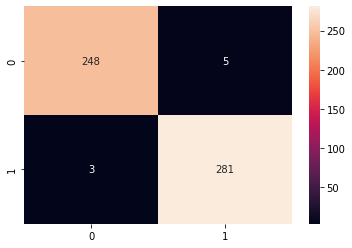

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       253
           1       0.98      0.99      0.99       284

    accuracy                           0.99       537
   macro avg       0.99      0.98      0.99       537
weighted avg       0.99      0.99      0.99       537



In [ ]:
results = eval(X_test, y_test, model_vgg, True)
show_acc(results)

Vemos que da un mejor resultado, siendo un 99% de Acc. Y con solamente 8 imagenes mal clasificadas, al utilizar un modelo mas potente estamos obteniendo un mejor resultado para este problema de clasificacion. Ahora como el caso anterior vamos a ver las imagenes que son "mas" Pokemon y "mas" Digimon, de las imagenes acertadas y la erroneas. Y tambien la que tiene mas dudas el clasificador.

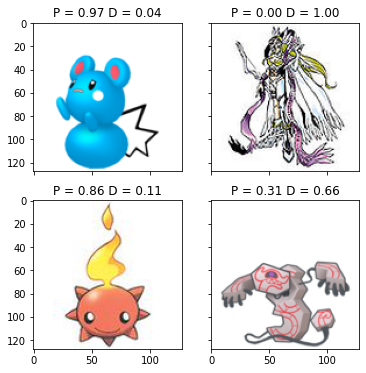

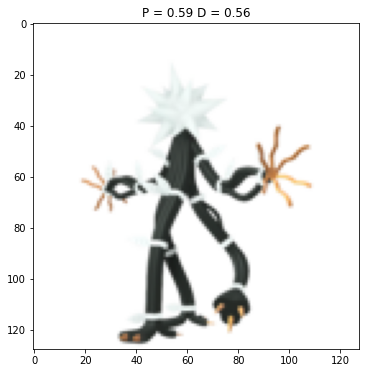

In [ ]:
eval_img(results)

Viendo de nuevo estas imagenes, nos podemos dar cuenta que la complejidad de los trazos del dibujo es muy importante, tal y como hemos visto en el analisis de las imagenes. Esto se puede deducir mirando las imagenes mal clasificadas. Como se puede observar en el Digimon con una prediccion del P = 0.86 D = 0.11 (Siendo P = Pokemon y D = Digimon) el modelo ha realizado una mala clasificacion, ya que sus trazos son muy sencillos. De la misma manera el Pokemon mal clasificado es porque tiene un diseño mas complejo (mas parecido a los Digimons).

El problema de estos modelos es que se han entrenado siempre con las mismas imagenes y durante poco tiempo. Y que, aun teniendo unos muy buenos resultados, no es capaz de aprender por patrones, texturas, etc. Por eso vamos ha realizar un ultimo entrenamiento con el modelo VGG16 pero esta vez pre-entrenado, para ver como un modelo que ya ha aprendido ha entender patrones mas complejos en las imagenes es capaz de realizar una mejor clasificacion.

#### 7. Probando un modelo preentrenado

Ahora entrenaremos el mismo modelo VGG16, pero entrenado con el dataset de IMAGENET que es el dataset por defecto ofrece Pytorch. Para ello a la hora de instanciar el modelo pasamos por paramentro `pretrained=True` con solamente esta linea, Pytorch descargara el modelo pre-entrenado.

In [ ]:
def vgg_pre():
    model = models.vgg16(pretrained=True)
    model.classifier[6]=nn.Linear(4096,2)
    return model

Nuevamente, si quieremos solamente cargar el modelo que he entrenado ejecutamos esta celda.

In [11]:
checkpoint = torch.load('/content/drive/MyDrive/models/vgg-pre.pt')
model_vgg_pre = vgg()
model_vgg_pre.cuda()
model_vgg_pre.load_state_dict(checkpoint['model_state_dict'])
train_loss = checkpoint['train_loss']
validation_acc = checkpoint['validation_acc']

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

En caso de querer entrenar ejecutar la siguiente celda.

In [ ]:
train_on_gpu = torch.cuda.is_available()
torch.cuda.empty_cache()
model_vgg = vgg_pre()

validation_acc = []
train_loss = []

optimizer_inception = optim.Adam(model_vgg.parameters(), lr=0.000001)
criterion_inception = nn.CrossEntropyLoss()

if train_on_gpu: model_vgg.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for epoch in range(0, 29):  # loop over the dataset multiple times
  train(model_vgg, optimizer_inception, criterion_inception, train_set, 10, train_loss)
  validate(model_vgg, criterion_inception, valid_set, validation_acc)

print('Finished Training of Inception')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Epoca 1 Batch 192 Train loss 0.15964996293187142
Validation Accuracy: 97 %
Validation Loss: 3.933197248727083
Epoca 2 Batch 192 Train loss 0.047567345667630434
Validation Accuracy: 98 %
Validation Loss: 1.5001775678247213
Epoca 3 Batch 192 Train loss 0.0374635383952409
Validation Accuracy: 99 %
Validation Loss: 0.8802334498614073
Epoca 4 Batch 192 Train loss 0.007164975901832804
Validation Accuracy: 99 %
Validation Loss: 0.6255173957179068
Epoca 5 Batch 192 Train loss 0.02458917647600174
Validation Accuracy: 99 %
Validation Loss: 0.5182475997426081
Epoca 6 Batch 192 Train loss 0.0030515374790411444
Validation Accuracy: 99 %
Validation Loss: 0.34783431380128604
Epoca 7 Batch 192 Train loss 0.0010831462888745591
Validation Accuracy: 99 %
Validation Loss: 0.28739207185572013
Epoca 8 Batch 192 Train loss 0.0028515199075627605
Validation Accuracy: 99 %
Validation Loss: 0.2468348971378873
Epoca 9 Batch 192 Train loss 0.0006806606907048263
Validation Accuracy: 99 %
Validation Loss: 0.18984695

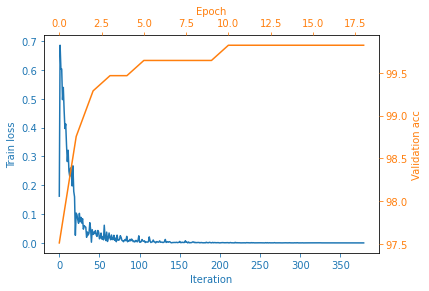

Last train loss: 3.625503363764437e-05 Last validation acc: 99.82238010657194


In [ ]:
plot_train_loss_acc(train_loss, validation_acc)
print('Last train loss:',train_loss[-1], 'Last validation acc:', validation_acc[-1])

A diferencia de los otros dos entrenamientos ha consegido que el loss sea mucho mas estable y en un numero de epocas menos (10 epocas), solamente con esas epocas ya tenemos un 99,8% de Acc.

In [ ]:
torch.save({
            'epoch': 29,
            'model_state_dict': model_vgg.state_dict(),
            'optimizer_state_dict': optimizer_inception.state_dict(),
            'loss': train_loss[-1],
            'train_loss': train_loss,
            'validation_acc': validation_acc
            }, 'models/vgg-pre.pt')

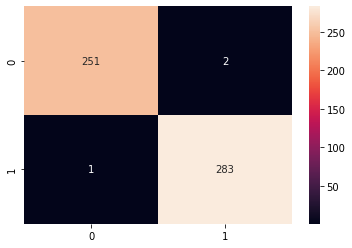

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       253
           1       0.99      1.00      0.99       284

    accuracy                           0.99       537
   macro avg       0.99      0.99      0.99       537
weighted avg       0.99      0.99      0.99       537



In [ ]:
results = eval(X_test, y_test, model_vgg_pre, True)
show_acc(results)

Evaluando el modelo con los datos de test, optenemos un Acc del 0,99, solamente 3 imagenes mal clasifiadas.

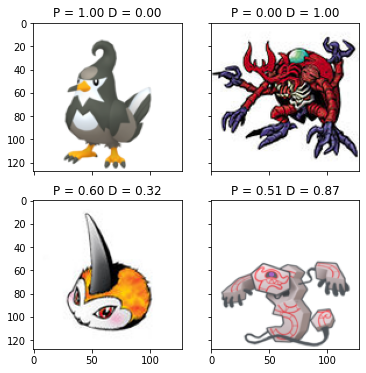

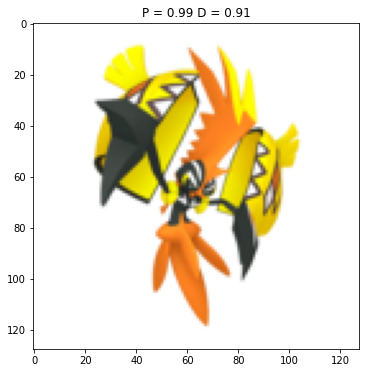

In [ ]:
eval_img(results)

Vemos que se repite el mismo patron que en los 2 otros modelos, uno de los dibujos mas sencillos de Digimon y pequeño ha sido confundido como Poquemon. Pero porque este modelo ha tenido un mejor Acc que el resto de modelos, eso es lo que veremos a continuacion.

#### 8. Analisis de los modelos

Una de las cosas que podemos ver, para poder evaluar el modelos es mirar por dentro que partes de la imagen tiene mas peso (importancia) como Pokemon y que partes como Digimon. Para ello podemos usar una herramienta "parecida" a Microscope de OpenIA, https://microscope.openai.com/models.

La herramienta en cuestion es Flashtorch que se encuentra dentro de la libreria Torchcam (https://github.com/MisaOgura/flashtorch), dentro de este modulo podemos encontrar la clase Backprop que de manera textual por el autor hace lo siguiente "provide indications of the most salient regions within images. By creating a saliency map for neural networks, we can gain some intuition on "where the network is paying the most attention to" in an input image."

Aplicaremos este proceso para las imagenes de test para ver que es lo que mas importancia le da el modelo ha la hora de realizar la prediccion.

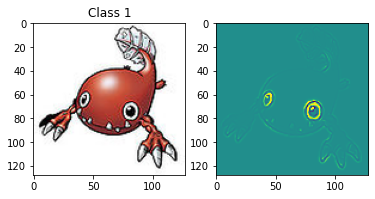

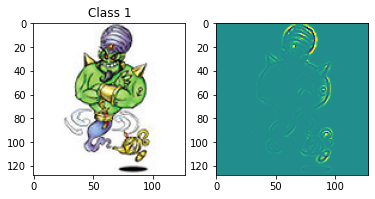

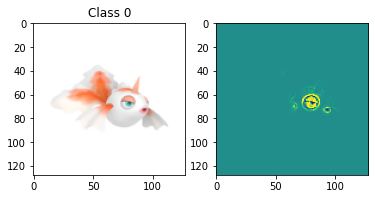

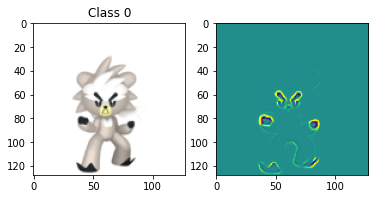

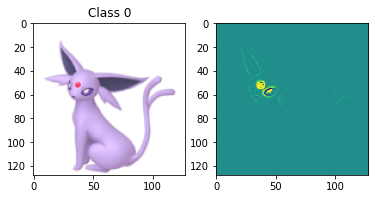

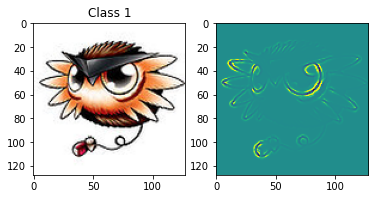

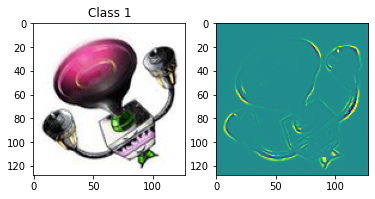

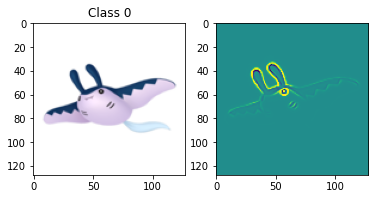

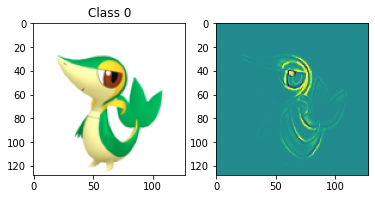

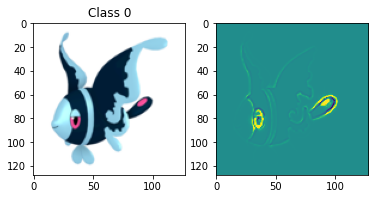

In [ ]:
def show_max_gradients(X_test, y_test, model):
    model.cpu()
    asc = Backprop(model)
    for img, lab in zip(X_test, y_test):
        img2 = prepara_test_img(img, False)
        max_gradients = asc.calculate_gradients(img2, lab, take_max=True, guided = True)
        # Show two images with their respective gradients
        plt.subplot(1, 2, 1)
        plt.title('Class ' + str(lab))
        plt.imshow(img)
        plt.subplot(1, 2, 2)
        plt.imshow(format_for_plotting(standardize_and_clip(max_gradients)))
        plt.show()
        
show_max_gradients(X_test[20:30], y_test[20:30], model_vgg_pre)

Podemos observar que cuando se trata de un Pokemon (clase 0), el modelo da mas importancia a los ojos (tambien a formas redondas), en cambio cuando es un Digimon el modelo da mas importancia a los trazos de los bordes. Pero claro esto se ha realizado con el modelo pre-entrenado, que es capaz de encontrar estos patrones. Vamos a ver como se comporta el modelo que no ha sido pre-entrenado.

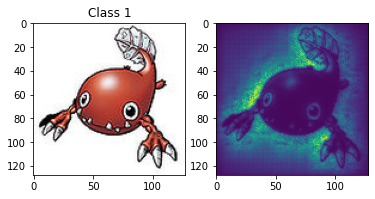

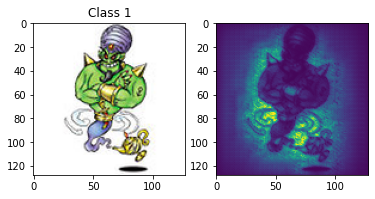

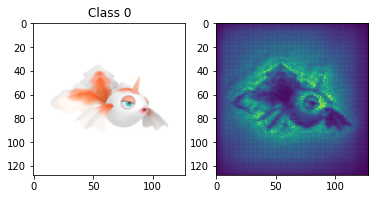

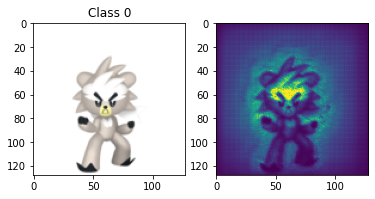

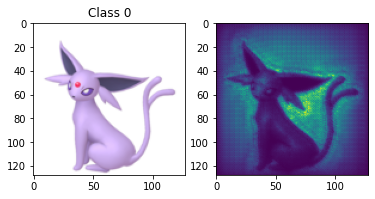

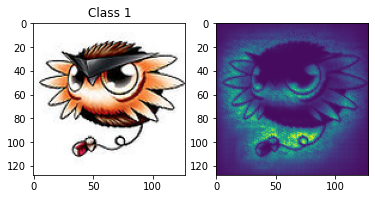

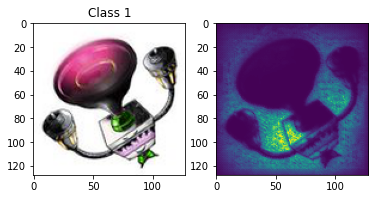

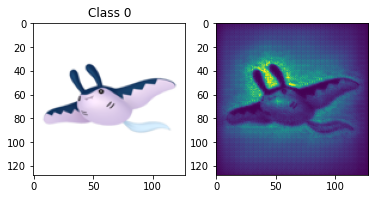

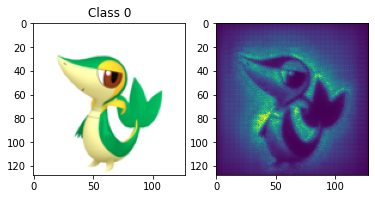

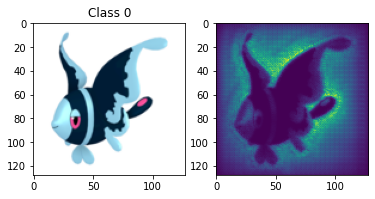

In [ ]:
show_max_gradients(X_test[20:30], y_test[20:30], model_vgg)

Ahora vemos que es completamente distinta las zonas en la que el clasificador se fija. Vemos que el modelo aprende de la silueta del modelo y no de las caracteristicas del dibujo, como por ejemplo los ojos, que si hacia el modelo pre-entrenado VGG16. Finalmente vamos a ver como un modelo mas sencillo que zonas son las que prioriza para la clasificacion.

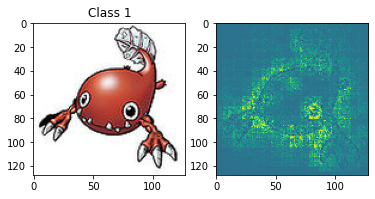

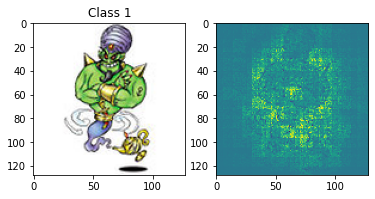

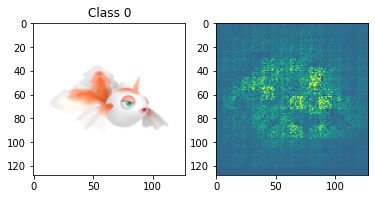

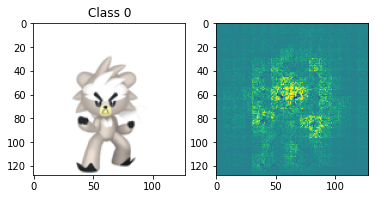

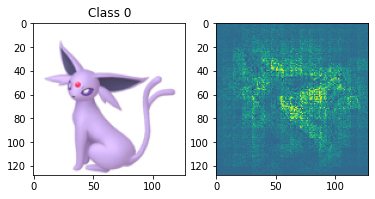

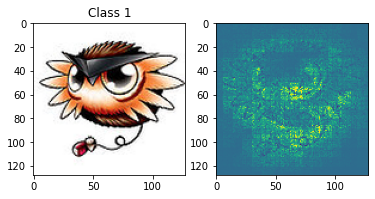

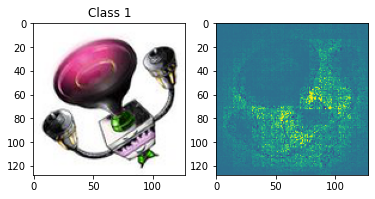

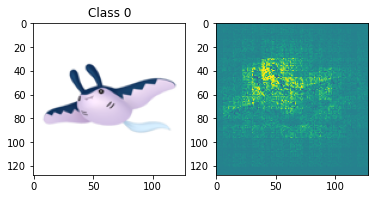

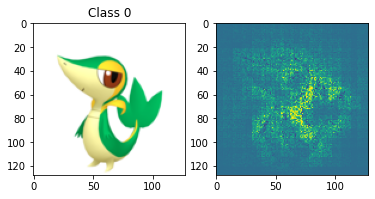

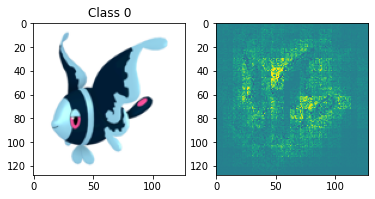

In [ ]:
show_max_gradients(X_test[20:30], y_test[20:30], model)

Podemos ver que igual que el modelo VGG sin pre-entrenamiento, este se guia mas por la figura del dibujo y no por sus caracteristicas.

#### 9. Extra

Como extra vamos a ver que pasa cuando realizamos inferencia sobre imagenes que no son Pokemons ni Digimos, para ello he pedido a un amigo que me pase una foto de su perra.

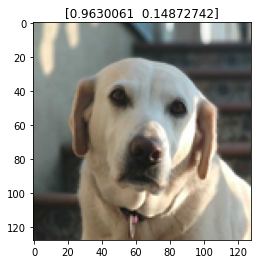

In [ ]:
test_one('perra.jpg', model_vgg_pre)

Podemos observar que el modelo ha clasificado como Pokemon (con un 0.96 de confidencia) la perra de mi amigo. A continuacion pasaremos mi foto de perfil de Github para ver que predice.

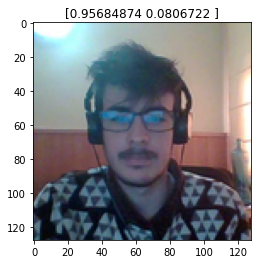

In [ ]:
test_one('juanma.jpg', model_vgg_pre)

Tambien he salido como Pokemon con un 95% de confidencia.

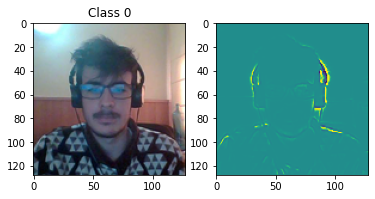

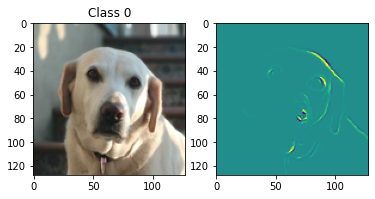

In [ ]:
juanma = load_img('juanma.jpg')
perro = load_img('perra.jpg')
show_max_gradients([juanma, perro], [0, 0], model_vgg_pre)

En la parte superior podemos ver cual han sido las partes mas importantes para la clasificacion. A diferencia que los pokemon, parece que se ha fijado bastante en los bordes, al ser imagenes del mundo real y no tener bordes pronunciados, es por ese el motivo por el cual nos ha clasificado como Pokemon (Es una suposicion). Finalmente como prueba final relizare dos dibujos distintos, un Pokemon y un Digimon inventados, para ver si aplicando el conocimiento que hemos sacado de la investigacion soy capaz de que el classificador realize la clasificacion que yo quiero.

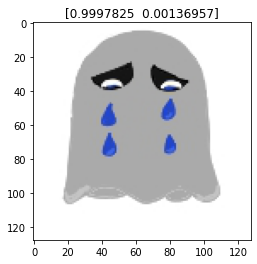

In [ ]:
model_vgg_pre.cpu()
test_one('pokemon.jpg', model_vgg_pre)

Podemos que el dibujo que he creado como Pokemon, el modelo lo ha clasificado como pokemon con una confidencia practicamente del 100%. La idea para que el dibujo lo classifique como pokemon ha sido no utilizar bordes, formas esfericas y ojos grandes. Estas son las caracteristicas mas tipicas de un Pokemon.

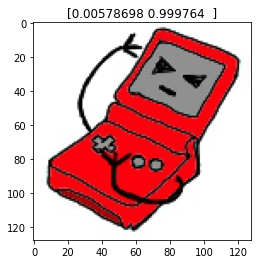

In [ ]:
model_vgg_pre.cpu()
test_one('digimon.jpg', model_vgg_pre)

Por otro lado he dibujado un "Digimon" que tambien los ha detectado como Digimon con una confidencia practicamente del 100%. Para este dibujo he buscado formas mas cuadradas, bordear todo el dibujo con un color negro y ojos menos esfericos.

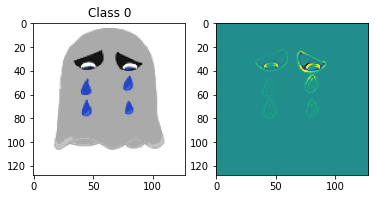

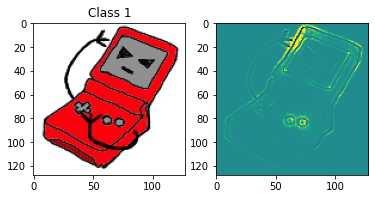

In [ ]:
pokemon_ = load_img('pokemon.jpg')
digimon_ = load_img('digimon.jpg')
show_max_gradients([pokemon_, digimon_], [0, 1], model_vgg_pre)

Como podemos ver la suposicion hecha anteriormente se cumple, he sido capaz de generar dos dibujos distintos y que sean clasificados como he querido, esto gracias a poder ver el modelo de manera interna para asi poder entender y aprender cual son las caracteristicas mas importantes de cada clase.

Aunque el modelo es bastante robusto.

In [52]:
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.squeeze(0)     #remove batch dimension # B X C H X W ==> C X H X W
    x = x.cpu().detach().numpy() #reverse of normalization op- "unnormalize"
    x = np.transpose( x , (1,2,0))   # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.cpu().detach().numpy() #reverse of normalization op
    x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = x_grad.squeeze(0).cpu().detach().numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()

In [14]:
def zero_gradients(x):
    if isinstance(x, torch.Tensor):
        if x.grad is not None:
            x.grad.detach_()
            x.grad.zero_()
    elif isinstance(x, collections.abc.Iterable):
        for elem in x:
            zero_gradients(elem)



In [106]:
def adversial_example(X_test, y_test, epsilon, alpha = 0.025, num_steps = 10):
  y_target = Variable(torch.LongTensor([int((not bool(y_test)))]), requires_grad=False).cuda()
  img_tensor = prepara_test_img(X_test, True)
  img_variable = Variable(img_tensor, requires_grad=True)
  img_variable.data = img_tensor

  for i in range(num_steps):
      zero_gradients(img_variable)
      output = model_vgg_pre.forward(img_variable)
      loss = torch.nn.CrossEntropyLoss()
      loss_cal = loss(output, y_target)
      loss_cal.backward()
      x_grad = alpha * torch.sign(img_variable.grad.data)
      adv_temp = img_variable.data - x_grad
      total_grad = adv_temp - img_tensor
      total_grad = torch.clamp(total_grad, -epsilon, epsilon)
      x_adv = img_tensor + total_grad
      img_variable.data = x_adv

  output_adv = model_vgg_pre.forward(img_variable)
  real_adv = model_vgg_pre.forward(img_tensor)

  output_adv_probs_adv = torch.softmax(output_adv, dim=1).cpu().detach().numpy()[0]
  output_adv_probs_real = torch.softmax(real_adv, dim=1).cpu().detach().numpy()[0]

  visualize(img_tensor, img_variable.data, total_grad, epsilon, output_adv_probs_real.argmax(), output_adv_probs_adv.argmax(), output_adv_probs_real, output_adv_probs_adv)

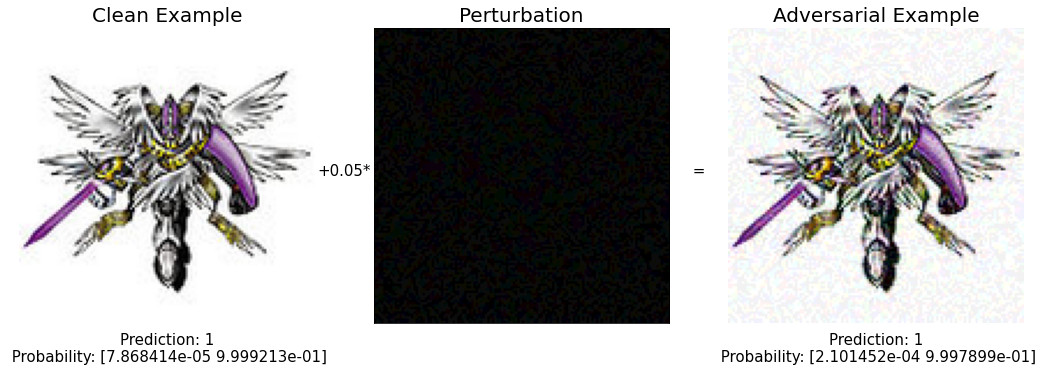

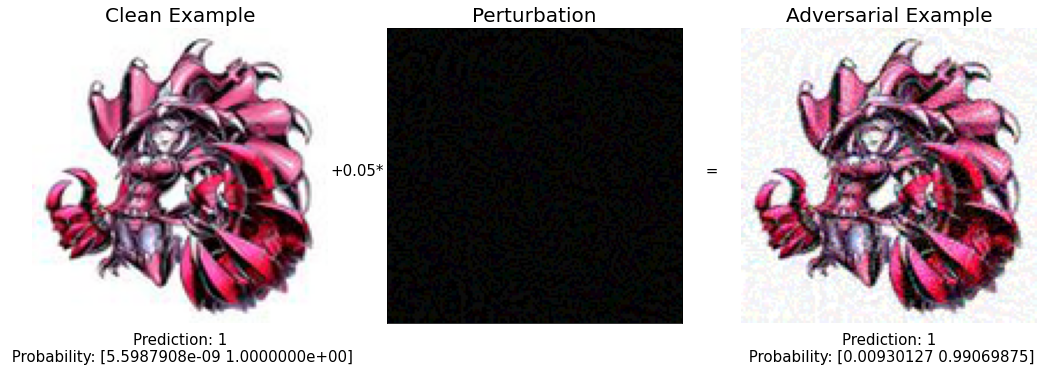

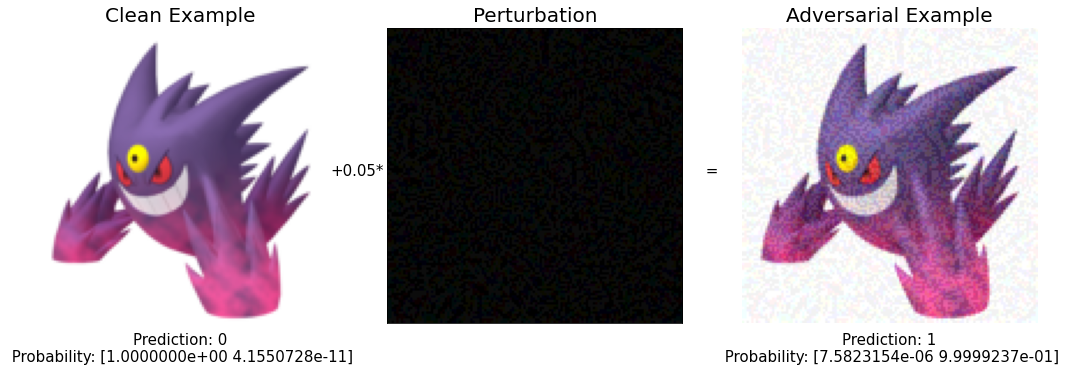

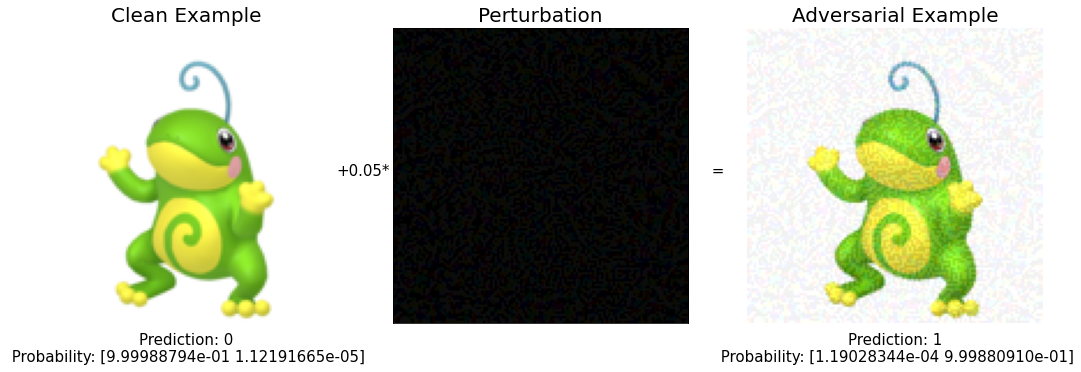

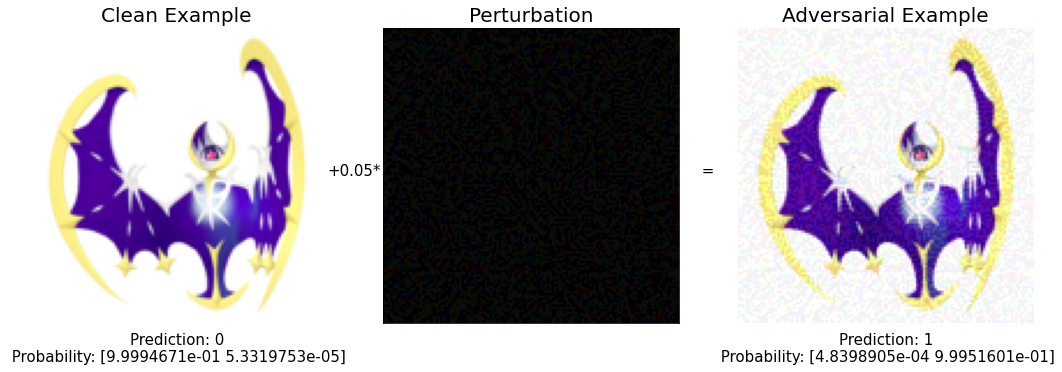

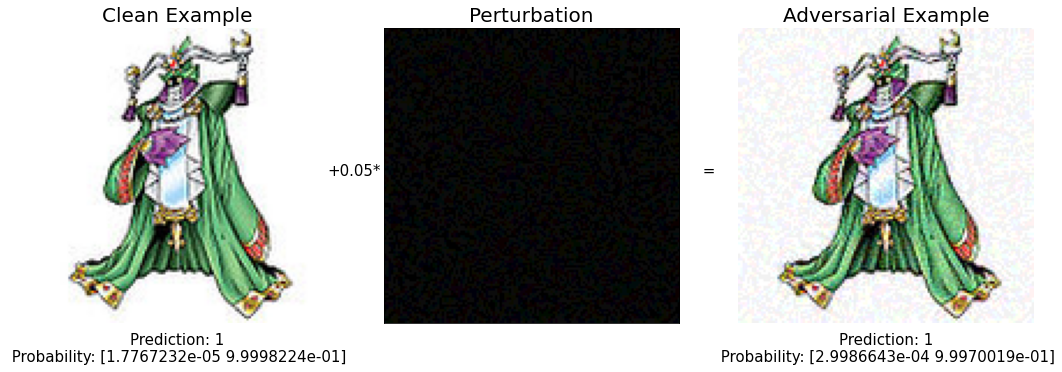

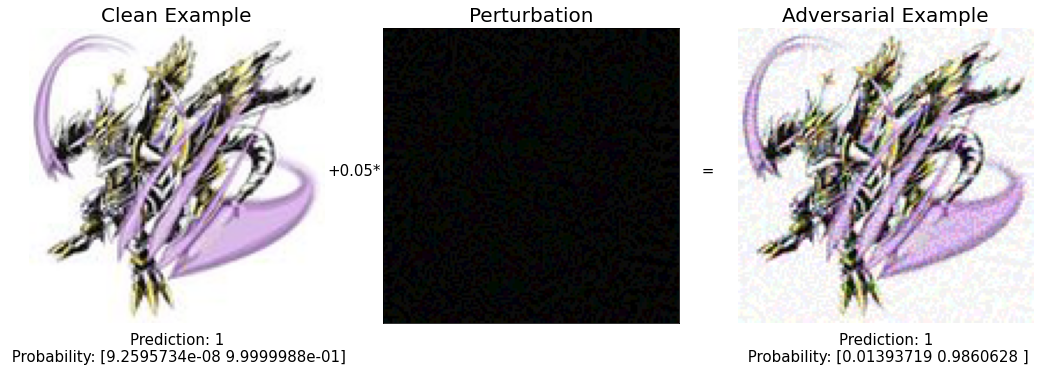

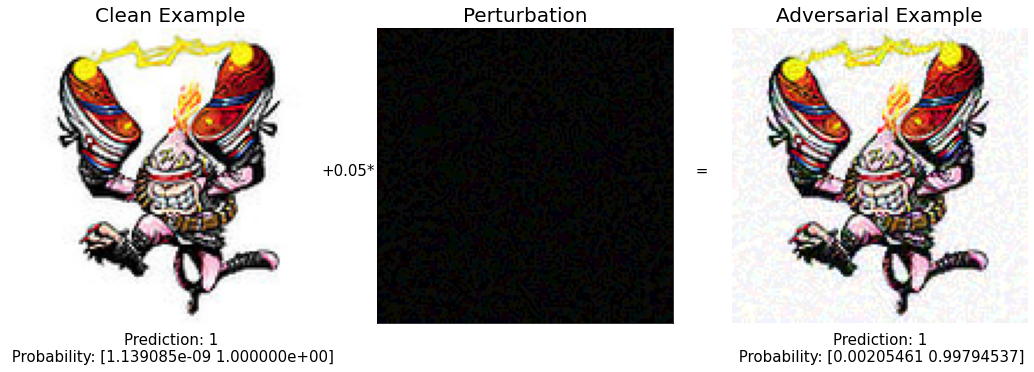

In [107]:
for x, y in zip(X_test[46:54], y_test[46:54]):
  adversial_example(x, y, 0.05, 0.1, 20)

#### 11. Conclusiones

A lo largo del notebook he entrenado dos modelos distintos y uno pre-entrenado. 

#### 12. Referencias

- https://qiita.com/mrok273/items/6f0bcdc62b6184f79308 (Esta en japones, realiza una comparativa de Pokemon y Digimon del tipo de dibujo)
- https://github.com/MisaOgura/flashtorch (Libreria para la visualizacion de los pesos de modelo)
- https://microscope.openai.com/models (Pagina web de la idea del apartado del analisis de modelo)
- https://www.kaggle.com/kvpratama/pokemon-images-dataset (Dataset de pokemon, no usado finalmente)
- https://github.com/DeathReaper0965/Digimon-Generator-GAN/blob/master/Digimon.zip (Dataset utilizado para los Digimons)
- https://pokemondb.net/pokedex/shiny (Dataset utilizado para los Pokemon)
- https://pytorch.org/docs/stable/index.html (Documentacion pytorch)
- https://savan77.github.io/blog/imagenet_adv_examples.html (Adversarial Example)